In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import grad, vmap, random

key = random.PRNGKey(0)  # random seed

## Introduction



JAX is a Python module that allows for transformations of Python and Numpy code, namely:

+ Vectorization

+ Just In Time (JIT) compilation

+ Automatic Differentiation

## JIT

JAX has a decorator that performs Just In Time compilation of Python code to C,

In [ ]:
from jax import jit

@jit
def jit_logistic(x):
  return 1.0 / (1.0 + np.exp(-x))

In [ ]:
%%timeit 
logistic(0.0)

The slowest run took 32.96 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 558 µs per loop


In [ ]:
%%timeit
jit_logistic(0.0)

The slowest run took 339.71 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 60.6 µs per loop


The second function was almost ten times faster (!)

## Vectorization

Consider the typical numpy function:

In [174]:
def sums(x):
  return np.sum(x)

n = 10
xs = np.arange(n*n).reshape(n,n)
xs

DeviceArray([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
             [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]], dtype=int32)

The next code sums the number for each line. There are $n$ function calls to `sums`,

In [165]:
[sums(row) for row in xs]  # sum each line

[DeviceArray(45, dtype=int32),
 DeviceArray(145, dtype=int32),
 DeviceArray(245, dtype=int32),
 DeviceArray(345, dtype=int32),
 DeviceArray(445, dtype=int32),
 DeviceArray(545, dtype=int32),
 DeviceArray(645, dtype=int32),
 DeviceArray(745, dtype=int32),
 DeviceArray(845, dtype=int32),
 DeviceArray(945, dtype=int32)]

Using `vmap`, there is only one function call that performs the vectorized operation over an axis of the matrix,

In [166]:
vmap(sums)(x) # vectorized sum each line 

DeviceArray([ 45, 145, 245, 345, 445, 545, 645, 745, 845, 945], dtype=int32)

In [167]:
vmap(square, in_axes=1)(x)  # vectorized sum each column 

DeviceArray([450, 460, 470, 480, 490, 500, 510, 520, 530, 540], dtype=int32)

## Using JAX to compute derivatives

Function `grad(f)` produces the derivative function of `f`.

Say, for $f(x)=x^2$, `grad(f)` is function $f'(x)=2x$

In [ ]:
def f(x):
  return x**2

df_dx = grad(f)

print(f(3.0), df_dx(3.0))

9.0 6.0


It's also possible to compute partial derivatives.

Consider $f(x,y) = x + x^2y^3$. 

Let's define, using JAX, the function 

$$\frac{\partial^2f}{\partial x \partial y} = 6xy^2$$

In [ ]:
def f(x,y):
  return x + x**2 * y**3

df_dxdy = grad( grad(f,0), 1) # parameter argnum has default value 0

print( df_dxdy(1.5,2.0) ) # should produce 36.0

36.0


Another example, consider the logistic function

$$\text{logistic}(x) = \frac{1}{1 + e^{-x}}$$

Its derivative is given by expression

$$\text{logistic}'(x) = \frac{e^x}{(1+e^x)^2}$$

which is not trivial to calculate, but `grad` does it automatically,

In [ ]:
def logistic(x):
  return 1.0/(1.0 + np.exp(-x))

dlogistic_dx = grad(logistic)

v_dlogistic_dx = vmap(dlogistic_dx)

Function `vmap` makes the derivative function a vectorized function.

Let's also compute the second derivative and plot all functions together,

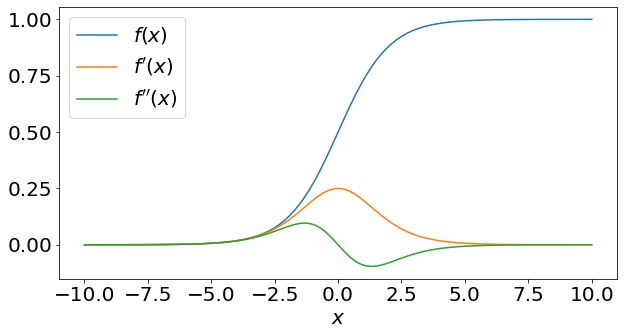

In [ ]:
v_dlogistic_dx2 = vmap(grad(dlogistic_dx))

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 20

x = np.linspace(-10.0, 10.0, 100)
fig, ax = plt.subplots()
ax.plot(x, logistic(x)       , label="$f(x)$")
ax.plot(x, v_dlogistic_dx(x) , label="$f'(x)$")
ax.plot(x, v_dlogistic_dx2(x), label="$f''(x)$")
ax.legend()
ax.set_xlabel("$x$");

Let's go thru several examples of how the automatic computation of derivatives can ease several statistical and machine learning tasks.

## Example: Approximating a solution for a functional equation


Given $f(t) = x^t$, what should be the value of $x$ such that $f(t) = f'(t)$?

In [175]:
def f(x,t):
  return np.power(x,t)

df_dt = grad(f,1)

We can transform the question into an optimization problem, by defining a loss function as the difference between f and f' at a given point (say, at 0) that must be minimized.

In [176]:
def loss(x):
  return f(x,0.0) - df_dt(x,0.0)

dloss_dx = grad(loss)

Let's implement Newton's method that works with the first derivative,

In [177]:
def newton(guess, loss, dloss, epsilon=1e-7):
  while abs(loss(guess)) > epsilon:
    guess -= loss(guess) / dloss(guess)
  return guess

Of course, we are expecting the number $e$,

In [178]:
print(newton(2., loss, dloss_dx), np.exp(1.))

2.7182817 2.7182817


## Example: Logistic Regression Model

In a Logistic Regression Model we have $k$ independent variables (or features) $X_1, \ldots, X_k \in \mathbb{R}$ and one binary dependent variable $Y \in \{0,1\}$.

Let's get some data,

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

X, y = load_breast_cancer(return_X_y=True)
n_features = X.shape[1]
n_samples = y.size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
y_train = y_train.reshape(len(y_train),1)

print(np.column_stack((X_train_s[:,0:5],y_train))) # show some X_i from some samples

[[-0.1923199   1.9522648  -0.25218529 -0.2699889  -1.5274794   1.        ]
 [-0.12960601 -0.68673503 -0.17477354 -0.23137489 -0.23141469  1.        ]
 [ 1.3327677   0.12406878  1.1971114   1.2858098  -0.49210042  0.        ]
 ...
 [ 1.3926309   1.148125    1.2426476   1.210887   -0.41404197  0.        ]
 [-0.13530727 -0.06474854 -0.10439924 -0.23195122 -0.39342278  1.        ]
 [ 1.0819122   1.1236899   0.96115047  0.9887124  -0.54217565  0.        ]]


We wish to find appropriate weights $b,W$ such that

$$p(Y=1|b,W,X) = \sigma\left( b + \sum_{i=1}^k w_iX_i \right)$$ 

where $\sigma$ is the logistic function, which maps $\mathbb{R} \rightarrow [0,1]$

The regression step is to find weights $b,W$ given some training data.

For simplicity, we will consider $b$ as weight $w_0$ over a columns of ones in the data set (i.e., $X_0$ is always 1).

In [ ]:
# add column of ones at the beginning of both train and test sets
X_train_s = np.column_stack((np.ones(X_train_s.shape[0]),X_train_s))
X_test_s = np.column_stack((np.ones(X_test_s.shape[0]),X_test_s))

print(np.column_stack((X_train_s[:,0:5],y_train))) # show some X_i from some samples

[[ 1.         -0.1923199   1.9522648  -0.25218529 -0.2699889   1.        ]
 [ 1.         -0.12960601 -0.68673503 -0.17477354 -0.23137489  1.        ]
 [ 1.          1.3327677   0.12406878  1.1971114   1.2858098   0.        ]
 ...
 [ 1.          1.3926309   1.148125    1.2426476   1.210887    0.        ]
 [ 1.         -0.13530727 -0.06474854 -0.10439924 -0.23195122  1.        ]
 [ 1.          1.0819122   1.1236899   0.96115047  0.9887124   0.        ]]


The logistic and prediction functions are thus defined as,

In [ ]:
def logistic(x):
  return 1.0/(1.0 + np.exp(-x))

# p( Y=1 | W,X )
def predict(W, X):
  return logistic(np.dot(X,W))

This model, despite the name, is more used for classification. 

Given data $x$ we predict its binary response $\hat{y}$ as

$$\hat{y} = 1 \iff \sigma(x) \geq 0.5$$

or $\hat{y} = 0$, otherwise.

Let's assume we have iid data

$$D = \{ (x^{(1)}, y^{(1)}), \ldots, (x^{(n)}, y^{(n)}) \}$$

We want to maximize the likelihood of this data according to our model,

$$\mathcal{L}(W) = p(D~|~W) = \prod_{i=1}^n p(y^{(i)} | x^{(i)},W) =  \prod_{i=1}^n \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right)^{y^{(i)}}  \left( 1- \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right)\right)^{1-y^{(i)}}$$

where

$$\sigma_{\textbf{w}}(x) = \sigma \left( \sum_{i=0}^k w_ix_i \right)$$

As usual, for numerical reasons, it's best to compute with log-likelihoods. Also, the negative sign makes this a minimization problem,

$$J(W) = - \frac{1}{n} \sum_{i=1}^n \left[  y^{(i)} \log \left(  \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right) \right) +  \left( 1-y^{(i)} \right) \log \left( 1- \sigma_{\textbf{w}} \left(\textbf{x}^{(i)} \right)\right) \right] $$

We can also add a [$l_2$ regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) to make the model more robust to overfitting,

$$J_{\text{reg}}(W) = J(W)  + \frac{\lambda}{2} \textbf{W}^T \textbf{W}$$

In Python this loss function is computed by the next function,

In [ ]:
def loss(W, X, y, eps=1e-14, lmbd=0.1):
  n = len(y)
  p = predict(W, X)
  p = np.clip(p, eps, 1-eps)  # bound probabilities within (0,1) to avoid ln(0)
  return (-(1.0/n) * np.sum(y * np.log(p) + (1-y) * np.log(1-p)) 
          + 0.5 * lmbd * np.dot(W.T, W) )[0][0]

Let's check the cost for a random assignment of weights, and then make a prediction vs the actual responses in the test set (as expected, we will get very poor results).

In [ ]:
W_rnd = random.uniform(key,(1+n_features,1), minval=-1e-5,maxval=1e-5)
print(loss(W_rnd, X_train_s, y_train))

y_predict = (predict(W_rnd, X_test_s) >= 0.5) * 1 # covert booleans to 0s,1s
print(classification_report(y_test, y_predict))

0.6931525
              precision    recall  f1-score   support

           0       0.30      0.47      0.37        53
           1       0.53      0.36      0.43        90

    accuracy                           0.40       143
   macro avg       0.42      0.41      0.40       143
weighted avg       0.45      0.40      0.40       143



+ Precision is the percentage of true positives among all positives, ie, $\frac{tp}{tp+fp}$

+ Recall is the percentage of positives correctly classified, ie, $\frac{tp}{tp+fn}$

+ Accuracy is $\frac{tp + tn}{n}$

(tp is true positive, fn is false negative, etc.)

How to compute the gradient of the loss function, i.e., $\nabla J_{\text{reg}}(W)$? With JAX, of course,

In [ ]:
grad_loss = grad(loss)

The next code performs [gradient](https://en.wikipedia.org/wiki/Gradient_descent) [descent](https://hackernoon.com/demystifying-different-variants-of-gradient-descent-optimization-algorithm-19ae9ba2e9bc) using this gradient,

In [ ]:
n_iter = 1000   # max iterations
eta = 0.01      # learning rate
tol = 1e-6      # maximum tolerance between sucessive costs to exit cycle
w = W_rnd       # initial random weights

cost = loss(w, X_train_s, y_train)  # initial cost
for i in range(n_iter):
  w -= eta * grad_loss(w, X_train_s, y_train)  # weight update rule
  old_cost, cost = cost, loss(w, X_train_s, y_train)
  if np.abs(cost - old_cost) < tol:
    break

print(loss(w, X_train_s, y_train)  )

0.19858


With the fitted weights, we can perform the classification of the test data set,

In [ ]:
y_predict = (predict(w, X_test_s) >= 0.5) * 1 
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93        53
           1       0.95      0.98      0.96        90

    accuracy                           0.95       143
   macro avg       0.95      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143



Now the results are much better.

We don't need to program the gradient descend algorithm. Python already includes (much faster) optimization procedures:

In [ ]:
from scipy.optimize import minimize

# not sure if all this reshaping is really necessary...
def f(coefs): 
  return loss(coefs.reshape(-1,1), X_train_s, y_train)

res = minimize(f, W_rnd.reshape(-1,), 
               method="BFGS", jac=grad(f), options={"gtol": 1e-4})

y_predict = (predict(res.x, X_test_s) >= 0.5) * 1 
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93        53
           1       0.95      0.98      0.96        90

    accuracy                           0.95       143
   macro avg       0.95      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143





---



## Model - Cost - Minimize

Eric Ma, in his [tutorial](https://www.youtube.com/watch?v=gGu3pPC_fBM&feature=youtu.be&t=2008), argues that many fit algorithms can be translated into a framework that composes of three steps:

1. Design a **model** that given parameters $\theta$ and variables $x$ is able to compute predictions $\hat{y} = f(\theta,x)$

1. Define a **cost** function (also called **loss** function) that given true measures $y$ and predictions $\hat{y}$ evaluates how close the predictions are

1. Given data $x,y$, use an **optimizer** to minimize the cost function wrt $\theta$ 

### Example: Linear Regression

In [ ]:
import numpy.random as npr

# make some linear data
n = 10  # number data samples
p = 2   # number independent variables
x = np.array(npr.randn(n*p)).reshape(n,p)

b = np.array([1])    # unknown parameters
w = np.array([3,-2])  
noise = npr.normal(0,.1,size=n)

y = x @ w + b + noise

A model includes unobserved variables (the parameters), $\theta$, and observed variables (the independent variables), $X$.

In this example, we want to use a linear model, applying the standard cost equal to the sum of the square of the residuals,

In [ ]:
# Step 1 - The model
def linear_model(theta, x):
  b = theta[0]
  w = theta[1:]
  return x @ w + b
  
# Step 2 - The cost function
def cost(theta, model, x, y):
  y_pred = model(theta, x)
  residuals = y - y_pred
  return np.mean( np.power(residuals, 2) )

# Step 3 - The minimizer
f = lambda theta : cost(theta, linear_model, x, y) # objective function
res = minimize(f, npr.normal(size=1+p), method="BFGS", jac=grad(f))  
# check optimized parameters
print("Thetas:", res.x)

# Make some predictions
y_predict = linear_model(res.x, x)
print("Predictions", y_predict)

Thetas: [ 0.99592639  2.94021588 -2.03098127]
Predictions [ 0.66301703 -0.4110465   6.5323715  -4.492866    3.814309   -1.5885575
 -2.4802008  -3.6488686  -5.8240976   3.7628262 ]


### Example: Logistic Regression

The same method can be applied for logistic regression (we'll use the previous data set),

In [ ]:
# Step 1 - The model
def logistic_model(theta, X):
  return logistic(X @ theta)

# Step 2 - The cost function
def cost(theta, model, X, y, eps=1e-14, lmbd=0.1):
  n = len(y)
  p = model(theta, X)
  p = np.clip(p, eps, 1-eps)  # bound probabilities within (0,1) to avoid ln(0)
  return (-(1.0/n) * np.sum(y * np.log(p) + (1-y) * np.log(1-p)) 
          + 0.5 * lmbd * np.dot(theta.T, theta) )[0][0]  # with regularization

# Step 3 - The minimizer
f = lambda theta : cost(theta.reshape(-1,1), logistic_model, X_train_s, y_train)
res = minimize(f, W_rnd, method="BFGS", jac=grad(f))

# Make some predictions
y_predict = (logistic_model(res.x, X_test_s) >= 0.5) * 1 
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93        53
           1       0.95      0.98      0.96        90

    accuracy                           0.95       143
   macro avg       0.95      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143



## Example: Dealing with Probability Models

Let's first make some data denoted $y$:

In [86]:
import numpy.random as npr
npr.seed(101)

mu    = 10
sigma = 5
n     = 100
y = npr.normal(loc=mu,scale=sigma,size=n)

Assume the following full probability model for $y$,

$$y_i \sim \mathcal{N}(\mu, \sigma^2)$$

$$\mu \sim \mathcal{N}(0, 10)$$

$$\sigma \sim \text{Gamma}(2,0.1)$$

Given data $y$ we wish to infer the posterior distributions $p(\mu|y)$ and $p(\sigma|y)$.

The next function computes the unnormalized log posterior, given values for parameters $\theta = \{\mu,\sigma\}$,

In [74]:
import jax.scipy.stats as ss

def log_posterior(theta, y):
  log_lik         = np.sum( ss.norm.logpdf(y, theta[0], theta[1]) )
  log_prior_mu    = ss.norm.logpdf( theta[0], 0, 10)
  log_prior_sigma = ss.gamma.logpdf( theta[1], 2, 0.01)
  return log_lik + log_prior_mu + log_prior_sigma

We can apply `minimize`, together with JAX, to maximize this posterior expression wrt $\theta$.

Here's the optimization step:

In [84]:
from scipy.optimize import minimize

f = lambda theta : -log_posterior( theta, y )

res = minimize(f, np.array([4,4]), method="BFGS", jac=grad(f))
res.x

array([10.80410848,  5.0671986 ])

And it's done! Here are the results against the true parameters,

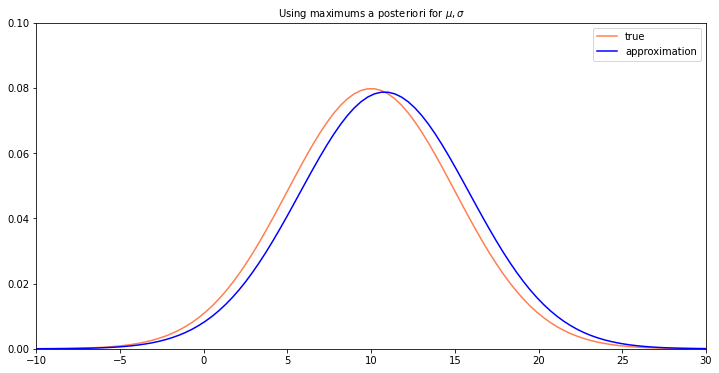

In [99]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,6))

x_min, x_max = -10,30
x = np.linspace(x_min, x_max, 100)
y_true = ss.norm.pdf(x,mu,sigma)
plt.plot(x,y_true, color='coral')

y_pred = ss.norm.pdf(x,res.x[0],res.x[1])
plt.plot(x,y_pred, color='blue')

plt.xlim(x_min,x_max)
plt.ylim(0,0.1)
plt.title('Using maximums a posteriori for $\mu,\sigma$',fontsize=10)
plt.legend(['true', 'approximation'])
plt.show()

To check the uncertainty relative to each posterior distribution, we can use the parameter means and covariate matrix to produce samples via a multivariate normal. Btw, this is the distribution we would obtain if we have done a Laplace Approximation!

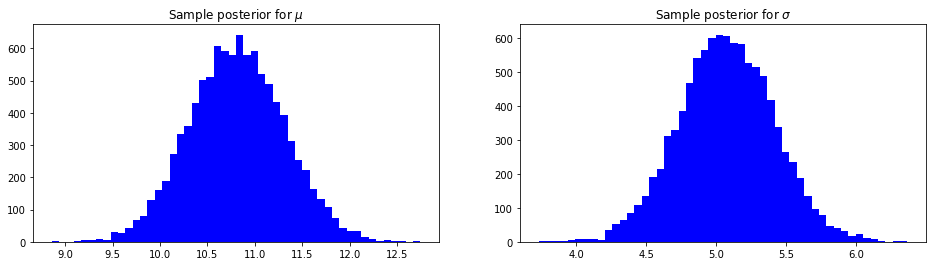

In [98]:
# generate lots of samples...
samples = npr.multivariate_normal(res.x, res.hess_inv, size=10_000)

# ...and plot them
fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=2)
axes[0].hist(samples[:,0], bins=50, color='b')
axes[0].set_title('Sample posterior for $\mu$')
axes[1].hist(samples[:,1], bins=50, color='b')
axes[1].set_title('Sample posterior for $\sigma$');

## References

+ Will Kurt, [Autodiff to find $e$](https://gist.github.com/willkurt/f29863fc5be9414a2e91d818846079c7)

+ François Pacull, [Logistic Regression with JAX](https://www.architecture-performance.fr/ap_blog/logistic-regression-with-jax/)

+ Angus Williams, [A brief introduction to JAX and Laplace’s method](https://anguswilliams91.github.io/statistics/computing/jax/)

+ Eric J. Ma, [Demystifying Deep Learning for Data Scientists](https://youtu.be/gGu3pPC_fBM?t=2008) (70min youtube tutorial); GitHub at https://github.com/ericmjl/dl-workshop

+ Rasmus Bååth, [Easy Laplace Approximation](http://www.sumsar.net/blog/2013/11/easy-laplace-approximation/)

+ alexbw@, mattjj@, [The Autodiff Cookbook](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/autodiff_cookbook.ipynb#scrollTo=iZDL-n_AvgBt)
